<a href="https://colab.research.google.com/github/parththegoat1234/MoneyBall_Project/blob/main/Moneyball_Project_Section_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

# Notebook 2: Putting the "money" in Moneyball

Congratulations on getting through the first notebook and learning about the ins and outs of baseball! Now that we have some overall background, we'll shift focus to start some analysis on how individual batters' performance metrics can influence salaries. In this notebook we will:
* look at the new `batting` and `salaries` dataset
* understand how to merge different datasets
* use machine learning to predict salaries
* identify undervalued players

# Milestone 1: Introducing the `batting` and `salaries` datasets

In [ ]:
#@title Run this to download data and prepare our environment!
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ------------------ BATTING ------------------
batting = pd.read_csv("https://drive.google.com/uc?id=17IM9kxyscGEpu-4Ov5p7MpCKz9UVHLla")

# Rename columns to be more descriptive
abbrev_map = {
    "R" : "Runs",
    "AB" : "AtBats",

    "H"  : "Hits",
    "2B" : "Doubles",
    "3B" : "Triples",
    "HR" : "HomeRuns",
    "RBI": "RunsBattedIn",

    "BB"  : "Walks",
    "IBB" : "IntentionalWalks",
    "HBP" : "HitsByPitch",
    "SF"  : "SacrificeFlies",
    "SH"  : "SacrificeHits",

    "SB"   : "StolenBases",
    "CS"   : "CaughtStealing",
    "SO"   : "Strikeouts",
    "GIDP" : "GroundedIntoDoublePlays",

    "W" : "Wins",
    "L" : "Losses",
    "G" : "Games",
}

batting = batting.rename(columns=abbrev_map)
batting = batting.loc[batting["AtBats"] > 130] # remove rookies' rows

# Take data from multiple stints and put it in one row
batting = batting.groupby(['playerID', 'yearID']).sum(numeric_only=True)
batting = batting.sort_values(['playerID', 'yearID'])
batting = batting.reset_index()
batting = batting.drop(columns='stint')

# Add in number of seasons played
seasonsPlayed = batting.groupby('playerID')['yearID'].cumcount()
batting.insert(batting.columns.get_loc('yearID') + 1, 'SeasonsPlayed', seasonsPlayed)


# Add in features from NB1
batting["BattingAverage"] = batting.eval("Hits / AtBats")
batting["OnBasePercentage"] = batting.eval("(Hits + Walks + HitsByPitch) / (AtBats + Walks + HitsByPitch + SacrificeFlies)")
batting["SluggingPercentage"] = batting.eval("(Hits + Doubles + 2*Triples + 3*HomeRuns) / AtBats")


# ------------------ SALARIES ------------------
# load in salaries data
salaries = pd.read_csv("https://drive.google.com/uc?id=16wlS8fmyZ43sATfeSZ8eUAqR5543pg_G")
salaries = salaries.loc[salaries['salary'] > 0]
salaries = salaries.drop(columns="lgID")

# Remove players with multiple stints
salaries = salaries[~salaries.duplicated(subset=['playerID', 'yearID'], keep=False)]

# For people's names
people = pd.read_csv("https://drive.google.com/uc?id=1QkDGU9p0L1JqiubZwQl_ZqVbGltbWwKF")

# Rename the 'yearID' column to 'year' in both batting and salaries datasets
batting = batting.rename(columns={"yearID": "year"})
salaries = salaries.rename(columns={"yearID": "year_salary"})

## Exploring the Batting Dataset

Having gained a solid understanding of various aspects of baseball, it's time for us to dive into some new datasets and apply our knowledge.

We'll start by focusing on individual player performance. The `batting` dataset offers a wealth of information about players' batting statistics. *Note that this is different from the `teams` dataset we were using in the previous notebook, since this includes statistics for each player each year they played!*

To get a feel for this dataset and the kind of data it contains, let's begin by examining the first couple of rows! In the code cell below, write code to display the first 9 rows of the `batting` dataset. This will give us a quick look into the data we'll be working with and set the stage for our upcoming analysis, discussions, and more!

In [ ]:
batting.head(9)

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,Walks,Strikeouts,IntentionalWalks,HitsByPitch,SacrificeHits,SacrificeFlies,GroundedIntoDoublePlays,BattingAverage,OnBasePercentage,SluggingPercentage
0,aaronha01,1954,0,122,468,58,131,27,6,13,...,28,39.0,0.0,3.0,6.0,4.0,13.0,0.279915,0.322068,0.446581
1,aaronha01,1955,1,153,602,105,189,37,9,27,...,49,61.0,5.0,3.0,7.0,4.0,20.0,0.313953,0.366261,0.539867
2,aaronha01,1956,2,153,609,106,200,34,14,26,...,37,54.0,6.0,2.0,5.0,7.0,21.0,0.328407,0.364885,0.558292
3,aaronha01,1957,3,151,615,118,198,27,6,44,...,57,58.0,15.0,0.0,0.0,3.0,13.0,0.321951,0.377778,0.600000
4,aaronha01,1958,4,153,601,109,196,34,4,30,...,59,49.0,16.0,1.0,0.0,3.0,21.0,0.326123,0.385542,0.545757
5,aaronha01,1959,5,154,629,116,223,46,7,39,...,51,54.0,17.0,4.0,0.0,9.0,19.0,0.354531,0.401154,0.635930
6,aaronha01,1960,6,153,590,102,172,20,11,40,...,60,63.0,13.0,2.0,0.0,12.0,8.0,0.291525,0.352410,0.566102
7,aaronha01,1961,7,155,603,115,197,39,10,34,...,56,64.0,20.0,2.0,1.0,9.0,16.0,0.326700,0.380597,0.593698
8,aaronha01,1962,8,156,592,127,191,28,6,45,...,66,73.0,14.0,3.0,0.0,6.0,14.0,0.322635,0.389805,0.618243


### (Optional) Reviewing the Features from the Previous Notebook

As you may have noticed, we've added in the Batting Average, On-Base Percentage, and Slugging Percentage columns for you! Here are some quick definitions to refresh yourself:

1. `BattingAverage` - Measures how often a player gets a hit.
2. `OnBasePercentage` - Reflects how often a player reaches base, including walks and hits.
3. `SluggingPercentage` - Indicates the total bases a player records per at-bat, highlighting their power hitting.

For our discussion today, let's explore how these metrics interrelate and contribute to a player's overall offensive value.

- How do these all complement each other?
- In what ways might they tell different stories about a player's performance?
- Consider scenarios where a player might have a high value in one of these stats but not the others. What could this imply about their playing style and contribution to the team?







### (Optional) Discussing the New Features

Beyond those features we've discussed at length, there are some new ones! We've provided some definitions below for you. We will be using these as a part of our model

These first few are fairly self-explanatory:

- `StolenBases`: The number of bases a player successfully stole during the season, representing their ability to advance to the next base while the ball is in play.
- `CaughtStealing`: The number of times a player attempted to steal a base but was tagged out by the opposing team, indicating unsuccessful base-stealing attempts.
- `Strikeouts`: The number of times a player was put out by three strikes during their time at bat, reflecting their difficulty in making contact with the ball.
- `RunsBattedIn`: The number of runs a player contributed to their team's score by successfully batting in baserunners who were already on base.


These might be a little newer to you:
- `IntentionalWalks`: The number of times a pitcher intentionally walked a player by throwing four pitches outside the strike zone, often done strategically to avoid facing a strong hitter.
- `SacrificeHits`: The number of times a player intentionally bunted the ball in an attempt to advance a baserunner while sacrificing their own chance of getting on base.
- `GroundedIntoDoublePlays`: The number of times a player hit a ground ball that resulted in a double play, indicating the end of their team's offensive inning due to a defensive play by the opposing team.

Feel free to have your NB1 open with definitions, or take a look at the MLB glossary: https://www.mlb.com/glossary

## Adding in Seniority

Before moving on to salary discussions, we can add in some new features that would help us in the salary prediction process!

Let's add features that will tell us if our baseball players are arbitration eligible or free agents. Here are some descriptions:

- **Arbitration Eligible**: In baseball, players become eligible for arbitration once they've entered their third season and they become ineligible once they've entered their sixth season in the league. During arbitration, players negotiate contracts with their teams for the upcoming season, or an arbitrator decides on a salary if an agreement isn't reached.

- **Free Agent**: In baseball, a free agent is a player not under contract with any team, allowing them to sign with any team they choose. Free agency typically occurs when a player's contract expires, or after they've begun six years of service time in the Major Leagues, granting them the freedom to negotiate new contracts with various teams.


Why might adding these columns in be important for our later salary prediction?

### ✍ Exercise: Adding in the Seniority Columns

Based on the above definitions, add in the `isArbitrationEligible` and `isFreeAgent` columns! Which column might be useful to determine these?




In [ ]:
batting["isArbitrationEligible"] = (3 <= batting["SeasonsPlayed"]) & (batting["SeasonsPlayed"] < 6)
batting["isFreeAgent"] = 6 <= batting["SeasonsPlayed"]

batting.head()

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,IntentionalWalks,HitsByPitch,SacrificeHits,SacrificeFlies,GroundedIntoDoublePlays,BattingAverage,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent
0,aaronha01,1954,0,122,468,58,131,27,6,13,...,0.0,3.0,6.0,4.0,13.0,0.279915,0.322068,0.446581,False,False
1,aaronha01,1955,1,153,602,105,189,37,9,27,...,5.0,3.0,7.0,4.0,20.0,0.313953,0.366261,0.539867,False,False
2,aaronha01,1956,2,153,609,106,200,34,14,26,...,6.0,2.0,5.0,7.0,21.0,0.328407,0.364885,0.558292,False,False
3,aaronha01,1957,3,151,615,118,198,27,6,44,...,15.0,0.0,0.0,3.0,13.0,0.321951,0.377778,0.600000,True,False
4,aaronha01,1958,4,153,601,109,196,34,4,30,...,16.0,1.0,0.0,3.0,21.0,0.326123,0.385542,0.545757,True,False


### 💡 Discussion Question

Technically, we don't need a third column that tells us if a player has had less than 3 years of experience. Why might that be?

# Examining the Salaries Dataset

Now, let's shift our focus to another crucial aspect of baseball analytics: player salaries. Understanding how players are compensated is vital for both team management, player negotiations, and a team's economic success.

The `salaries` dataset provides detailed information about the salaries of baseball players.

To start, we'll take a quick look at the `salaries` dataset by running the cell below. What do each of the columns represent?


In [ ]:
salaries.head()

,year_salary,teamID,playerID,salary
0,1985,ATL,barkele01,870000
1,1985,ATL,bedrost01,550000
2,1985,ATL,benedbr01,545000
3,1985,ATL,campri01,633333
4,1985,ATL,ceronri01,625000


### ✍ Exercise: Exploring Summary Statistics

To further your understanding of the `salaries` dataset, let's apply a practical data analysis technique. The `.describe()` method will provide key statistical measures for each column in the dataset, such as mean, standard deviation, minimum, maximum, and quartile values.

In the code cell below, use the `.describe()` method on `salaries`.



In [ ]:
salaries.describe()

,year_salary,salary
count,26216.000000,2.621600e+04
mean,2000.925427,2.097156e+06
std,8.918734,3.465773e+06
min,1985.000000,1.090000e+04
25%,1994.000000,3.000000e+05
50%,2001.000000,5.500000e+05
75%,2009.000000,2.368985e+06
max,2016.000000,3.300000e+07


### 💡 Discussion Questions

- The maximum salary is `3.300000e+07`. What does this notation mean?
- What do the statistics for these two columns say about our data overall?
- What trends or disparities in player compensation might you see from this information?


### ✍ Exercise: Plotting the Salary Data

To get a better sense of the salary data, let's take a look at a histogram! A histogram is a type of plot that allows to plot how frequently values occur in a dataset. The $x$-axis will represent the data values of interest, while the $y$-axis will represent the counts!

Use this template code to fill in the code cell below and plot your histogram. Discuss the what each part of the plot means and shape of the overall distribution!

```python
sns.histplot(x="COLUMN", data=DATAFRAME)
```

<Axes: xlabel='salary', ylabel='Count'>

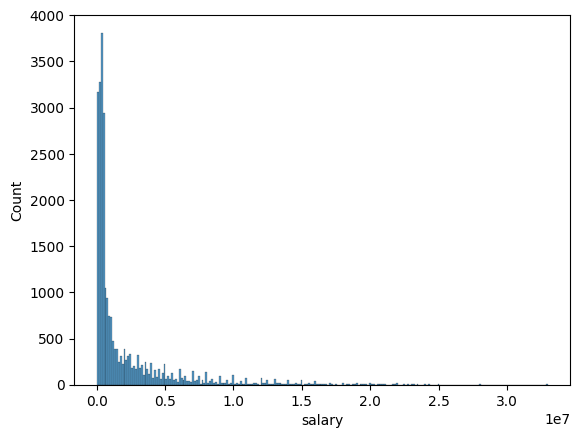

In [ ]:
sns.histplot(x="salary", data=salaries)

## Logarithmic Scaling

When preparing data for machine learning models, it's better to have a dataset that is not heavily skewed. Our current `salaries` dataset exhibits significant skewness, as observed in the distribution of salary values. (Feel free to scroll back up to take another look!)

### Transforming Data with Logarithms
- A common and effective technique to address skewness in data is through logarithmic scaling. If you're unfamiliar with logarithms, here's a brief explanation:
  
  The logarithm of a number $ n $ with a given base $ b $ is denoted as $ \log_b(n) $ and is defined as the exponent $ x $ to which the base $b$ must be raised to produce $ n $. Mathematically, it's expressed as:
  
  $$ \log_b(n) = x \quad \Longrightarrow \quad b^x = n $$

  In simpler terms, the logarithm tells us how many times we need to multiply the base $ b $ by itself to get the number $ n $.

### Applying Logarithmic Scaling to Salaries

- By applying logarithmic scaling to the salary data, we can transform the wide range of salaries into a more manageable and comparable scale.
- For example, using a base of 10, we can compare how many times 10 fits into the minimum and maximum salaries. In this case, 10 fits approximately 4 times into \\$10,000 and 7 times into \\$33 million.
- This scaling makes it easier for our machine learning model to understand and predict salaries, as it reduces the effect of extreme values and brings the data closer to a 'normal distribution'. (If you're not sure what a normal distribution is, ask your instructor!)

### ✍ Exercise: Transforming Salary Data with Logarithm

In this exercise, you'll learn how to transform and visualize the salary data in the `salaries` dataset to better understand its distribution. Transforming the data using a logarithmic scale can help reduce skewness and make patterns in the data more apparent.

**Task**:
- Create a new column in the `salaries` dataset named `"LogSalary"`.
- This column should contain the logarithm of each player's salary.
- Once the new column is added, plot the distribution of the transformed salaries.

**Hint**:
- You can use the `np.log10()` function from the NumPy library to calculate the logarithm with base 10 of the salaries.
- We've given you the plotting code below! FIll in the blanks & walkthrough with it with your instructor.


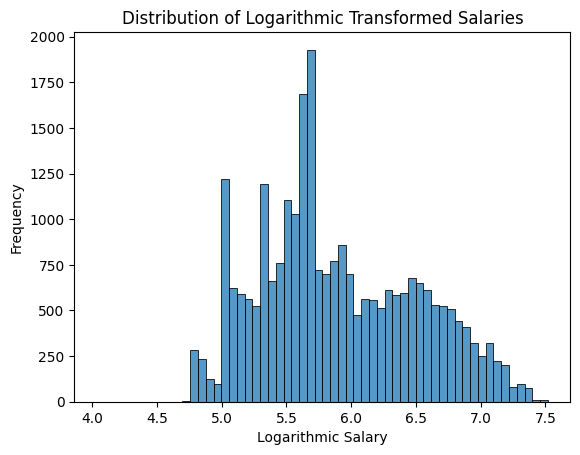

In [ ]:
salaries["LogSalary"] = np.log10(salaries["salary"])


sns.histplot(x="LogSalary", data=salaries).set(title='Distribution of Logarithmic Transformed Salaries', xlabel='Logarithmic Salary', ylabel='Frequency')
plt.show()

### ✍ Exercise: Examining the Year Feature

Now that we've explored the `batting` and `salaries` datasets, we can focus on using batting data to predict salaries. In the next section, we will merge these datasets to create a larger dataset where each row contains information for a specific `playerID` and `year` combination. This merged dataset will have a player's stats and salary for a given year.

However, there's an issue. If each row contains batting statistics and salaries for the same year, the statistics wouldn't help us predict the salary the player is already earning that year. To address this, we should ensure that the batting statistics are paired with the salary from the following year. This way, the models we create will predict future salaries based on current batting statistics. We will simulate this by offsetting the salary data.

When merging the datasets, if we use the same `year` for both batting statistics and salary, we end up predicting a salary that is already known, making the model unrealistic. By offsetting the salary data to the following year, we align the current year's batting statistics with the salary that those statistics would influence.

**As an example, if we have statistics on Yu Darvish's pitching stats in 2016, this would be used to predict the salary he would earn in 2017.**

In the code cell below, we'll create a new column `year_salary` in the `batting` dataset. This column will link a player's batting data in one year to his salary in the following year. How can we offset the `'year'` column to create this new column?


In [ ]:
batting['year_salary'] = batting['year'] + 1
batting.head(1)

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,HitsByPitch,SacrificeHits,SacrificeFlies,GroundedIntoDoublePlays,BattingAverage,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent,year_salary
0,aaronha01,1954,0,122,468,58,131,27,6,13,...,3.0,6.0,4.0,13.0,0.279915,0.322068,0.446581,False,False,1955


### Clarification on Merging Datasets

Now that we've created a new column in the `batting` dataset to indicate the corresponding salary year for each row of batting features, there's no further adjustment needed. This new column, named `year_salary`, matches the `year` column in the `salaries` dataset. Because of this, we can easily merge the two datasets using these columns to align each player's batting statistics with the correct salary year.

## Merging Datasets: Linking Player Data with Salaries

After exploring individual datasets, our next step is to integrate the player data with their salary information. This will allow us to analyze how player performance metrics correlate with their compensation.



### ✍ Exercise: Merging the Datasets

**Discussion**:
- Consider how we can create a comprehensive dataset that combines the details of players with their respective salaries.
- Reflect on the common columns between the two datasets we have explored: the `batting` dataset (or any other player performance dataset) and the `salaries` dataset.


Once you have a good idea of how you'd merge these datasets, use the `pd.merge()` function from the pandas library, specifying these common columns in the `on` parameter. Here's the template:

```python
merged_data = pd.merge(dataset1, dataset2, on=["col1", "col2"])
```

In [ ]:
merged_data = pd.merge(batting, salaries, on=['playerID', 'year_salary'])
merged_data.head()

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,GroundedIntoDoublePlays,BattingAverage,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent,year_salary,teamID,salary,LogSalary
0,abbotje01,1998,0,89,244,33,68,14,1,12,...,2.0,0.278689,0.298450,0.491803,False,False,1999,CHA,255000,5.406540
1,abbotje01,2000,1,80,215,31,59,15,1,3,...,2.0,0.274419,0.343096,0.395349,False,False,2001,FLO,300000,5.477121
2,abbotku01,1994,0,101,345,41,86,17,3,9,...,5.0,0.249275,0.290761,0.394203,False,False,1995,FLO,119000,5.075547
3,abbotku01,1995,1,120,420,60,107,18,7,17,...,6.0,0.254762,0.317597,0.452381,False,False,1996,FLO,250000,5.397940
4,abbotku01,1996,2,109,320,37,81,18,7,8,...,7.0,0.253125,0.307246,0.428125,False,False,1997,FLO,650000,5.812913


# Milestone 2: Salary Prediction

In this milestone, we shift our focus to one of the key objectives of our project: predicting baseball players' salaries. Building upon the data analysis and preprocessing steps we've completed so far, we are now ready to apply machine learning techniques to forecast salaries based on various player aspects.

**Objectives**:
- Utilize the enhanced dataset, which includes player performance metrics, experience categories, and other relevant features.
- Develop and train machine learning models capable of accurately predicting player salaries.
- Experiment with different modeling approaches, such as linear regression, decision trees, or more advanced techniques like random forests or neural networks.

**Goals**:
- Achieve a high degree of accuracy in salary predictions.
- Understand the factors that most significantly influence player salaries.
- Explore the relationship between player performance, experience, and compensation.

This milestone is crucial for understanding the dynamics of salary determination in professional baseball and showcases the practical application of data science in sports analytics.

### Exercise: Choosing the columns to focus on

In the provided code cell below, we will be able to focus our efforts on the columns of highest interest. Run the cell to choose columns you want to include in your analysis! The code cell will handle creating an `X` variable with scaled versions of the input features you choose, and a `y` variable with the `'LogSalary'` data.

Try to choose a set of columns different from your teammates, so that you all can explore what effects different combinations of features may have!

In [ ]:
#@title Run this to choose the columns
#@markdown NOTE: as you toggle the columns below, your `X` dataset will automatically update! Keep note of this if you change things after trying out your models below.
from ipywidgets import widgets
from sklearn.preprocessing import MinMaxScaler

# Columns to exclude from the checkboxes
exclude_columns = ['playerID', 'teamID', 'salary', 'year', 'year_salary', 'LogSalary']

# Create checkboxes for each column, excluding specific ones
checkboxes = {col:
                widgets.Checkbox(description=col, value=True)
                for col in merged_data.columns if col not in exclude_columns}

# Initial selection
bool_list = [(col not in exclude_columns) and checkboxes[col].value for col in merged_data.columns]
X = merged_data.loc[:, bool_list]
X_scaled = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
y = merged_data["LogSalary"]

# Function to update selected_columns based on checkbox values
def update_selected_columns(change):
    global X, bool_list
    bool_list = [(col not in exclude_columns) and checkboxes[col].value for col in merged_data.columns]
    X = merged_data.loc[:, bool_list]
    X_scaled = MinMaxScaler().fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

# Attach the callback to checkbox changes
for checkbox in checkboxes.values():
    checkbox.observe(update_selected_columns, 'value')

# Display checkboxes in a grid
widgets.GridBox(list(checkboxes.values()), layout=widgets.Layout(grid_template_columns="repeat(3, 200px)"))


GridBox(children=(Checkbox(value=True, description='SeasonsPlayed'), Checkbox(value=True, description='Games')…

Last step is to split the data as always! Why do we need to do this?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### ✍ Exercise: Initializing and fitting the model

In the code cell below, fit the `linear_model` we've initialized for you! How have we done this in the past with sklearn models?

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

### ✍ Exercise: Evaluating the model


Now that we've fit the model, we can take a look at the $R^2$ value for the fit. Recall that this metric focuses on how well our input features explain the variance in the dependent variable. Do you remember what good and bad values are for this?

In [ ]:
linear_model.score(X_test, y_test)

0.5977664687487672

Let's also take a look at the mean squared error, which is taking the difference between all the predictions and the true value, taking the square of those differences, and then taking the average. Of course, to have a good model, we'd want this value to be small.

Fortunately, with sklearn, we don't have to do all that math! You can use the following function to calculate this score, just like we've used `accuracy_score()` before:

```python
mean_squared_error(Y_TRUE, Y_PRED)
```

All you need to do is fill in those two input values! What would be our true $y$ (in other words, or true output)? How can we get the model's predictions? Try this out in the code cell below!

In [ ]:
predictions = linear_model.predict(X_test)
mean_squared_error(y_test, predictions)

0.13040857829632213

Let's also take a look at how the linear model weighs each of the input variables! We'll do this by taking a look at the relative magnitude of the coefficients of each input. In other words, we are taking the line of best fit $y = m_1x_1 + m_2x_2 + ...$ found from the linear regression and seeing which of the $m$s is largest in size, regardless of sign. A larger size coefficient means a given change in the input feature $x$ will have a larger effect on the overall output than a feature with a smaller coefficient!

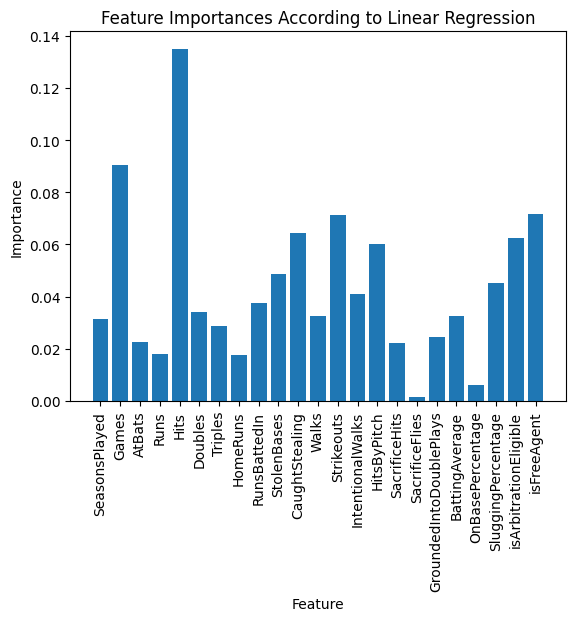

In [ ]:
#@title Run this to see the linear regression model importances!

# Get absolute values of the coefficients of the model
linear_model_importances = np.abs(linear_model.coef_)

# Normalize feature importances
linear_model_importances /= linear_model_importances.sum()

# Plot feature importances
plt.bar(X.columns, linear_model_importances, label='Linear Regression')
plt.title('Feature Importances According to Linear Regression')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## ✍ Exercise: Try a Decision Tree!

Try the same thing out with a decision tree! Do you remember how those work for classification? What might be different for this regression problem?

Remember that the code for sklearn is basically the same for every model. Can you complete the rest of the code cell below to train and evaluate the model? Feel free to experiment with the `max_depth` hyperparameter and others in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)!

In [ ]:
dt_model = DecisionTreeRegressor(max_depth=3)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)

print(f"R^2: {dt_model.score(X_test, y_test)}")
print(f"MSE: {mean_squared_error(y_test, predictions)}")

R^2: 0.5450406781667813
MSE: 0.14750286520959227


We’ve provided another code cell below to take a look at the feature importances for the decision tree model too! The feature importances for this model are a little more advanced: they’re calculated by taking a look at how much each feature cleanly splits the data at each node it’s used. If you’d like to learn more, check out [this resource on the Gini importance used in sklearn](https://www.codecademy.com/article/fe-feature-importance-final).

*Bonus question*: What happens to the number of nonzero feature importances as you change the `max_depth` of your decision tree? Why might that be?

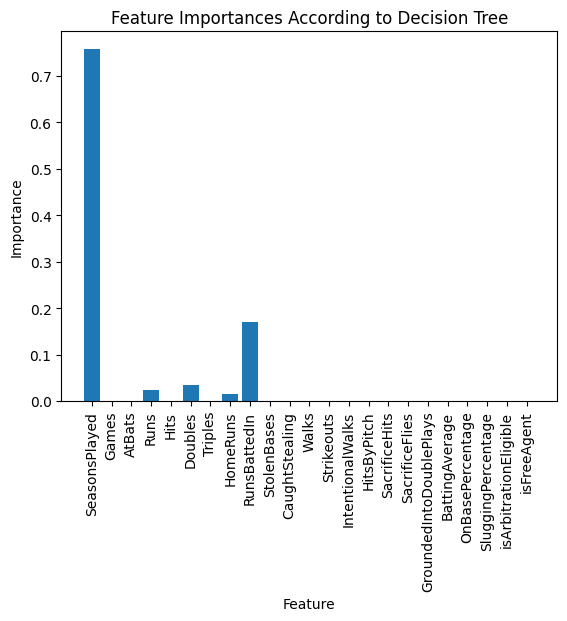

In [ ]:
#@title Run this to see the decision tree model importances!

# Get absolute values of the coefficients of the model
dt_importances = dt_model.feature_importances_

# Plot feature importances
plt.bar(X.columns, dt_importances)
plt.title('Feature Importances According to Decision Tree')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## (Optional) Exploring Other Models

That did pretty well! The next section will explore finding the most undervalued players, but, if your group has time and you're interested, you can see how other models might do. Feel free to try the following:

- `RandomForestRegressor`: basically a "forest" of decision trees that are each fit on different samples of the data. We determine the prediction by feeding the input to all the trees and taking the average of their predictions.
- `MLPRegressor`: a fully connected neural network. Remember to specify the hidden layer structure using the `hidden_layer_sizes` parameter!
- Any others you'd like to learn about from [sklearn's documentation](https://scikit-learn.org/stable/supervised_learning.html)!
  - Make sure you're using a model meant for regression (predicting values rather than categories)!
  - Make sure you also import whatever other models you try! The ones we've listed were already imported for you in the set-up cell.

In [ ]:
models = [RandomForestRegressor(max_depth=3),
          MLPRegressor(hidden_layer_sizes=(64,32)),
          ]

for model in models:
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)

  print(type(model).__name__)
  print(f"  R^2: {model.score(X_test, y_test)}")
  print(f"  MSE: {mean_squared_error(y_test, predictions)}")
  print()

RandomForestRegressor
  R^2: 0.5778206201709783
  MSE: 0.1368752439366825

MLPRegressor
  R^2: 0.6546258990633611
  MSE: 0.11197411947087511



# Milestone 3: Determining the most undervalued players

Now that we've explored some models to predict player salaries, let's take a look at who might be undervalued according to our model!

To identify the most undervalued players, we will take a look at the predicted `LogSalary` and compare it to the actual value. In the code cell below, make a new column called `LogSalaryDifference` that is the result of subtracting the true `LogSalary` from the prediction of your chosen model.

In [ ]:
predictions = linear_model.predict(X)
merged_data['LogSalaryDifference'] = predictions - merged_data['LogSalary']

Now what does this difference really mean? Let's dive back into the math. Here's what we have above:

$$ \text{LogSalaryDifference} = \log_{10}(\text{salary}_{\text{pred}}) - \log_{10}(\text{salary}_{\text{true}}) $$

A nifty rule of logarithms is that this is equivalent to

$$ \text{LogSalaryDifference} = \log_{10} \left( \frac{ \text{salary}_{\text{pred}} }{ \text{salary}_{\text{true}} } \right)$$

Another nifty rule of the logarithm we're using is that

\begin{align}
10^{\log_{10} x} = x
\end{align}

Putting all of this together, we have the following:

\begin{align}
10^\text{LogSalaryDifference} &= 10^{\log_{10} \left( \frac{ \text{salary}_{\text{pred}} }{ \text{salary}_{\text{true}} } \right)} \\
&= \frac{ \text{salary}_{\text{pred}} }{ \text{salary}_{\text{true}} }
\end{align}

meaning we can get the ratio of the predicted salary to the true salary by taking the exponent of our `LogSalaryDifference` column!

Since that's a lot of math to understand, we've provided the code below that adds a new column with this calculation, using `np.power()` which will do that $10^x$ calculation for every value in the input column.

In [ ]:
merged_data['SalaryRatio'] = np.power(10, merged_data['LogSalaryDifference'])

Run the cell below to sort the data by this ratio! What do values above 1 mean? What about below 1? Who are the most under- and overvalued players based on our model?

In [ ]:
merged_data.sort_values('SalaryRatio')

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent,year_salary,teamID,salary,LogSalary,LogSalaryDifference,SalaryRatio
3159,fukudko01,2010,2,130,358,45,94,20,2,13,...,0.370892,0.438547,False,False,2011,CHN,14500000,7.161368,-1.700156,0.019945
1657,castiru01,2015,0,80,273,35,69,10,2,5,...,0.288194,0.358974,False,False,2016,BOS,11400000,7.056905,-1.552530,0.028020
3805,guerral01,2015,0,106,219,25,51,9,1,11,...,0.260870,0.433790,False,False,2016,LAN,7500000,6.875061,-1.490057,0.032355
6092,matsuka01,2005,1,87,267,31,68,9,4,3,...,0.300000,0.352060,False,False,2006,NYN,8033333,6.904896,-1.422787,0.037776
3157,fukudko01,2008,0,150,501,79,129,25,3,10,...,0.358844,0.379242,False,False,2009,CHN,12500000,7.096910,-1.324331,0.047388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,collida02,1986,10,124,419,44,113,18,2,1,...,0.340471,0.329356,False,True,1987,CIN,100000,5.000000,1.158524,14.405354
533,baylodo01,1986,14,160,585,93,139,23,1,31,...,0.343523,0.439316,False,True,1987,OAK,731123,5.863990,1.178384,15.079397
9763,wardga01,1988,7,91,231,26,52,8,0,4,...,0.302326,0.311688,False,True,1989,NYA,68000,4.832509,1.231019,17.022345
1834,clarkja01,1992,15,81,257,32,54,11,0,5,...,0.350000,0.311284,False,True,1993,MON,109000,5.037426,1.371548,23.525980


# Congratulations on completing Notebook 2!

If you'd like to explore further, here are some suggestions:


- Focus on a smaller range of recent years! This will give us less data to train on, but it could remove any variables that we may not be able to account for with our current dataset, such as rule changes.
- Focus on specific subsets of the data, like the players with less experience who you may be able to get a better bargain for.